In [1]:
import eventstudy as es
import numpy as np
import matplotlib.pyplot as plt
import datetime
import yfinance as yf
import pandas as pd

# 检测输入数据

In [2]:
BSE = yf.download('MME=F', '2022-01-01', '2022-08-22')['Close']
ITC = yf.download('^BSESN', '2022-01-01', '2022-08-22')['Close']
print(type(BSE))
BSE

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.series.Series'>


Date
2022-01-03    1235.199951
2022-01-04    1230.400024
2022-01-05    1210.800049
2022-01-06    1216.599976
2022-01-07    1228.000000
                 ...     
2022-08-15    1019.000000
2022-08-16    1019.599976
2022-08-17    1015.099976
2022-08-18    1008.400024
2022-08-19     994.900024
Name: Close, Length: 159, dtype: float64

In [3]:
# to calcualte the return fo teh ITC and BSE sensex
ITC = ITC.pct_change()
BSE = BSE.pct_change()
ITC= pd.DataFrame(ITC)
BSE = pd.DataFrame(BSE)
BSE =BSE.dropna(axis=0)
ITC =ITC.dropna(axis=0)

# To have equal counts in ITC & BSE
df = ITC['Close'],BSE['Close']
df1 = pd.DataFrame(df)
df2 = df1.T
df2.columns = ['ITC','BSE']
df3 = df2.dropna()
df3

,ITC,BSE
Date,,
2022-01-04,0.011367,-0.003886
2022-01-05,0.006135,-0.015930
2022-01-06,-0.010317,0.004790
2022-01-07,0.002396,0.009370
2022-01-10,0.010896,-0.000081
...,...,...
2022-08-12,0.002194,0.010653
2022-08-16,0.006381,0.000589
2022-08-17,0.006984,-0.004413


# 模拟输入数据

In [4]:
###todo：数据要求
###todo：交易日期为 index，每一列的 column name 为股票代码，每一列是 close【收盘价】的percentage changed【百分比变化，相对于前一天】
stockData=pd.read_csv("stockData/TushareRawData.csv")
stockData=stockData[['ts_code','trade_date','pct_chg']].rename(columns={'trade_date':'date'})
# companyList=[]
afterColumnChanged=pd.DataFrame()
# print("total number of day: {}".format(len(stockData['Date'].values)))
# for stockCode in list(stockData.groupby('ts_code')):
#     theData={'Date':stockCode[1]['Date'].values,stockCode[0]:stockCode[1]['pct_chg'].values}
#     dataByCompany=pd.DataFrame(theData)
#     dataByCompany['Date']=pd.to_datetime(dataByCompany["Date"], format="%Y-%m-%d")
#     dataByCompany=dataByCompany.dropna(axis=1)
#     # dataByCompany=dataByCompany.set_index('Date')
#     # afterColumnChanged=afterColumnChanged.append(dataByCompany)
#     companyList.append(dataByCompany)
#     # afterColumnChanged=pd.concat([afterColumnChanged,dataByCompany])
#     # print("{} is finished".format(stockCode[0]))
#
# afterColumnChanged=pd.concat(companyList[:100])
# # afterColumnChanged=afterColumnChanged.drop_duplicates()
# afterColumnChanged=afterColumnChanged.sort_values(by='Date',ascending=False)
# # afterColumnChanged=afterColumnChanged.dropna(how='all')
stockData['date']=pd.to_datetime(stockData["date"], format="%Y-%m-%d")
# stockData['pct_chg']=stockData['pct_chg'].astype(float)
stockData=stockData.set_index('date')
# dt = datetime.datetime(2022, 12, 30)
# # for ele in afterColumnChanged[afterColumnChanged['Date']==dt].values:
# #     print(ele)
# afterColumnChanged

for stockCode in stockData.groupby('ts_code'):
    # if len(stockCode[1]['pct_chg'].values) >= 1000:
    afterColumnChanged[stockCode[0]]=stockCode[1]['pct_chg']

afterColumnChanged=afterColumnChanged.replace(np.nan,0)
# afterColumnChanged=afterColumnChanged.dropna(how="all")
afterColumnChanged

/var/folders/ct/s3lrfn2541b8hydxbp_njzch0000gn/T/ipykernel_3647/653033489.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  afterColumnChanged[stockCode[0]]=stockCode[1]['pct_chg']
/var/folders/ct/s3lrfn2541b8hydxbp_njzch0000gn/T/ipykernel_3647/653033489.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  afterColumnChanged[stockCode[0]]=stockCode[1]['pct_chg']
/var/folders/ct/s3lrfn2541b8hydxbp_njzch0000gn/T/ipykernel_3647/653033489.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of ca

,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,872392.BJ,872808.BJ,872925.BJ,873001.BJ,873122.BJ,873169.BJ,873223.BJ,873305.BJ,873339.BJ,873527.BJ
date,,,,,,,,,,,,,,,,,,,,,
2022-12-30,0.9977,0.2203,1.2552,0.5405,2.7732,0.0000,0.4367,0.9182,3.5912,1.0462,...,-2.5,2.3968,2.1127,0.5618,0.0000,0.0000,0.6270,0.6965,1.2121,-0.3713
2022-12-29,-0.8371,-2.2605,0.1047,-0.5376,-9.9853,-0.7653,-0.8658,-0.5809,-3.7234,-4.8922,...,0.0,0.4073,0.0000,-1.6575,-2.7539,-0.5017,-2.4465,-0.9852,-1.0000,0.2481
2022-12-28,0.2288,0.3782,-1.5464,-1.5873,2.5602,0.0000,-1.2821,-1.7129,-2.5907,1.0897,...,0.0,-0.1848,-0.7687,-7.2983,-0.0860,0.5042,-2.3881,-1.4563,-0.7937,0.1242
2022-12-27,2.6625,0.7621,2.5370,2.7174,9.9338,-0.3812,0.8621,-2.8526,0.5208,2.1404,...,0.0,-0.4781,-0.3482,-8.3333,-0.1717,0.0000,0.6006,2.7944,-0.1980,-0.1241
2022-12-26,-1.6179,-2.1832,1.2848,0.0000,2.1997,-0.6313,0.8696,1.2029,3.7838,-0.8489,...,0.0,-0.4029,0.6307,0.0000,4.0000,0.6768,0.0000,-0.5952,-0.3945,0.1242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-10,0.0600,0.0000,-0.4800,0.3400,1.0000,6.5300,0.6400,0.0000,0.0000,0.2800,...,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2013-01-09,-0.8800,0.0000,0.0000,0.0000,-1.3800,-0.3900,1.4700,1.7000,0.0000,-1.1200,...,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2013-01-08,-1.8400,0.0000,1.1000,0.3400,3.2500,8.0100,1.5900,-0.4500,0.0000,0.7100,...,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


这里筛选了一部分空值，如果有空值直接删除整行的话，只剩下2428 行

In [5]:
# afterColumnChanged.to_csv("eventStudyData/train/incomeImport.csv",sep=',',index =True)

In [6]:
afterColumnChanged=pd.read_csv("eventStudyData/train/incomeImport.csv",index_col="date")
afterColumnChanged.index=pd.DatetimeIndex(afterColumnChanged.index)
print(afterColumnChanged.index.dtype)
print(afterColumnChanged['000001.SZ'].dtypes)
afterColumnChanged

datetime64[ns]
float64


,000001.SZ,000002.SZ,000004.SZ,000005.SZ,000006.SZ,000007.SZ,000008.SZ,000009.SZ,000010.SZ,000011.SZ,...,872392.BJ,872808.BJ,872925.BJ,873001.BJ,873122.BJ,873169.BJ,873223.BJ,873305.BJ,873339.BJ,873527.BJ
date,,,,,,,,,,,,,,,,,,,,,
2022-12-30,0.9977,0.2203,1.2552,0.5405,2.7732,0.0000,0.4367,0.9182,3.5912,1.0462,...,-2.5,2.3968,2.1127,0.5618,0.0000,0.0000,0.6270,0.6965,1.2121,-0.3713
2022-12-29,-0.8371,-2.2605,0.1047,-0.5376,-9.9853,-0.7653,-0.8658,-0.5809,-3.7234,-4.8922,...,0.0,0.4073,0.0000,-1.6575,-2.7539,-0.5017,-2.4465,-0.9852,-1.0000,0.2481
2022-12-28,0.2288,0.3782,-1.5464,-1.5873,2.5602,0.0000,-1.2821,-1.7129,-2.5907,1.0897,...,0.0,-0.1848,-0.7687,-7.2983,-0.0860,0.5042,-2.3881,-1.4563,-0.7937,0.1242
2022-12-27,2.6625,0.7621,2.5370,2.7174,9.9338,-0.3812,0.8621,-2.8526,0.5208,2.1404,...,0.0,-0.4781,-0.3482,-8.3333,-0.1717,0.0000,0.6006,2.7944,-0.1980,-0.1241
2022-12-26,-1.6179,-2.1832,1.2848,0.0000,2.1997,-0.6313,0.8696,1.2029,3.7838,-0.8489,...,0.0,-0.4029,0.6307,0.0000,4.0000,0.6768,0.0000,-0.5952,-0.3945,0.1242
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-10,0.0600,0.0000,-0.4800,0.3400,1.0000,6.5300,0.6400,0.0000,0.0000,0.2800,...,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2013-01-09,-0.8800,0.0000,0.0000,0.0000,-1.3800,-0.3900,1.4700,1.7000,0.0000,-1.1200,...,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2013-01-08,-1.8400,0.0000,1.1000,0.3400,3.2500,8.0100,1.5900,-0.4500,0.0000,0.7100,...,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [7]:
###check null
check_for_nan = afterColumnChanged.isnull().values.any()
print("whether null value in data: ",check_for_nan)

whether null value in data:  False


# 模拟三因子数据 an aggregate of event

In [8]:
eventAggregate=pd.DataFrame()
companyTickers=afterColumnChanged.columns
companyTickers

Index(['000001.SZ', '000002.SZ', '000004.SZ', '000005.SZ', '000006.SZ',
       '000007.SZ', '000008.SZ', '000009.SZ', '000010.SZ', '000011.SZ',
       ...
       '872392.BJ', '872808.BJ', '872925.BJ', '873001.BJ', '873122.BJ',
       '873169.BJ', '873223.BJ', '873305.BJ', '873339.BJ', '873527.BJ'],
      dtype='object', length=5061)

In [9]:
spy=yf.download('SPY', '2022-01-01', '2022-08-22')['Close']

[*********************100%***********************]  1 of 1 completed


In [10]:
fama=pd.read_csv("eventStudyData/train/FamaFrench.csv")
print(fama['date'].dtypes)
fama[(20200110<=fama['date'])&(fama['date']<=20200130)]

int64


,date,Mkt-RF,SMB,HML,RF
24649,20200110,-0.34,-0.19,-0.33,0.006
24650,20200113,0.73,-0.11,-0.08,0.006
24651,20200114,-0.06,0.39,-0.18,0.006
24652,20200115,0.16,0.47,-0.81,0.006
24653,20200116,0.88,0.52,-0.11,0.006
24654,20200117,0.28,-0.64,-0.13,0.006
24655,20200121,-0.32,-0.51,-0.61,0.006
24656,20200122,0.08,-0.26,0.01,0.006
24657,20200123,0.08,-0.05,-0.13,0.006
24658,20200124,-0.97,-0.44,-0.29,0.006


## 输入数据

In [11]:
es.Single.import_returns('eventStudyData/train/incomeImport.csv')
es.Single.import_FamaFrench('eventStudyData/train/FamaFrench.csv')

In [12]:
event = es.Single.FamaFrench_3factor(
    security_ticker = '000504.SZ',
    event_date = np.datetime64('2020-01-20'),
    event_window = (-10,+10),
    estimation_size = 100,
    buffer_size = 25
)
event.results()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,AR,Std. E. AR,CAR,Std. E. CAR,T-stat,P-value
-10,-2.557,2.458,-2.557,2.458,-1.041,0.301
-9,-0.041,2.458,-2.599,3.476,-0.748,0.456
-8,-0.854,2.458,-3.453,4.257,-0.811,0.419
-7,4.957,2.458,1.504,4.915,0.306,0.760
-6,4.556,2.458,6.06,5.496,1.103,0.273
-5,-4.079,2.458,1.981,6.020,0.329,0.743
-4,-5.553,2.458,-3.572,6.502,-0.549,0.584
-3,-4.767,2.458,-8.338,6.951,-1.200,0.233
-2,-1.662,2.458,-10.001,7.373,-1.356,0.178
-1,1.072,2.458,-8.929,7.772,-1.149,0.253


In [13]:
event = es.Single.FamaFrench_3factor(
    security_ticker = '000615.SZ',
    event_date = np.datetime64('2020-01-20'),
    event_window = (-10,+10),
    estimation_size = 100,
    buffer_size = 25
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [14]:
afterColumnChanged.loc["2019-12-02":"2020-1-30"][['000504.SZ','000524.SZ','000004.SZ']]

,000504.SZ,000524.SZ,000004.SZ
date,,,
2020-01-23,-4.9242,-0.8333,-3.7131
2020-01-22,-1.2469,-0.2770,0.6369
2020-01-21,1.5190,-3.8615,0.9430
2020-01-20,-0.3783,-0.2656,4.9011
2020-01-17,-1.1222,-1.0512,-0.9795
2020-01-16,-0.7426,0.7947,-0.3991
2020-01-15,0.8739,-0.2642,-1.9565
2020-01-14,1.0088,0.2649,-0.1303
2020-01-13,-0.6266,0.2656,3.1348


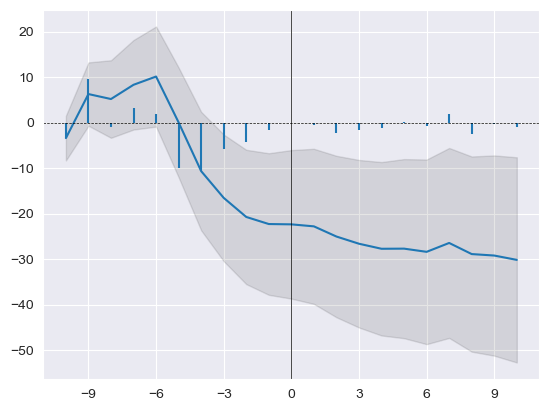

In [15]:
event.plot(AR=True)
plt.show()

In [16]:
event.results()

,AR,Std. E. AR,CAR,Std. E. CAR,T-stat,P-value
-10,-3.420,3.813,-3.42,3.813,-0.897,0.372
-9,9.674,3.813,6.254,5.393,1.160,0.249
-8,-1.090,3.813,5.164,6.605,0.782,0.436
-7,3.130,3.813,8.294,7.626,1.087,0.279
-6,1.813,3.813,10.107,8.527,1.185,0.239
-5,-10.085,3.813,0.022,9.340,0.002,0.998
-4,-10.702,3.813,-10.68,10.089,-1.059,0.292
-3,-5.877,3.813,-16.557,10.785,-1.535,0.128
-2,-4.194,3.813,-20.751 *,11.440,-1.814,0.073
-1,-1.555,3.813,-22.306 *,12.058,-1.850,0.067


# 筛选 5 只医药股（随机）

In [17]:
rawCompanyData=pd.read_csv("stockData/rawCompanyDataInTushare.csv")
print(rawCompanyData['industry'].unique())
rawMedicCompanyData=rawCompanyData[rawCompanyData['industry']=='医疗保健']['ts_code'].values.tolist()
rawMedicCompanyData=[i for i in rawMedicCompanyData if i in afterColumnChanged.columns]
rawMedicCompanyData=rawMedicCompanyData[:10]
# rawMedicCompanyData=[i for i in rawMedicCompanyData if (i !='000504.SZ' and i!='000615.SZ')][:5]
# rawMedicCompanyData=[i for i in rawMedicCompanyData if (i !='000504.SZ')][:5]
# rawMedicCompanyData=[i for i in rawMedicCompanyData if not afterColumnChanged[i].isnull().values.any()][:5]
# rawMedicCompanyData=['000001.SZ','000002.SZ']
rawMedicCompanyData

['银行' '全国地产' '软件服务' '环境保护' '区域地产' '其他商业' '运输设备' '电气设备' '建筑工程' '玻璃' '家用电器'
 '服饰' '农业综合' '元器件' '水泥' '汽车服务' '火力发电' '医药商业' '汽车配件' '综合类' '新型电力' '多元金融'
 '装修装饰' '房产服务' '商品城' '石油加工' '铅锌' '通信设备' 'IT设备' '港口' '机场' '石油贸易' '空运'
 '生物制药' '商贸代理' '化学制药' '影视音像' '工程机械' '证券' '化纤' '供气供热' '农药化肥' '机床制造' '百货'
 '中成药' '酒店餐饮' '路桥' '旅游景点' '造纸' '医疗保健' '食品' '黄金' '化工原料' '专用机械' '水运' '日用化工'
 '旅游服务' '文教休闲' '出版业' '机械基件' '汽车整车' '煤炭开采' '铁路' '染料涂料' '白酒' '农用机械' '林业'
 '水务' '水力发电' '互联网' '广告包装' '铝' '其他建材' '批发业' '保险' '小金属' '铜' '普钢' '航空' '饲料'
 '特种钢' '种植业' '焦炭加工' '纺织' '啤酒' '超市连锁' '钢加工' '矿物制品' '渔业' '软饮料' '化工机械' '塑料'
 '红黄酒' '仓储物流' '家居用品' '摩托车' '石油开采' '轻工机械' '电器仪表' '半导体' '乳制品' '纺织机械' '电器连锁'
 '陶瓷' '橡胶' '公路' '公共交通' '船舶' 'None' '电信运营' '园区开发']


['000504.SZ',
 '000516.SZ',
 '000615.SZ',
 '000710.SZ',
 '002022.SZ',
 '002030.SZ',
 '002044.SZ',
 '002086.SZ',
 '002172.SZ',
 '002173.SZ']

In [18]:
##todo：时间点：2020/1/20，2020/2/3
eventTime=['2020-12-20','2020-3-20']
# eventTime=['2020-1-20']
def createEventTime(eventTime,security_ticker,market_ticker):
    final=pd.DataFrame()
    for event in eventTime:
        for ticker in security_ticker:
            thisLine=pd.DataFrame({"security_ticker":[ticker],"market_ticker":[market_ticker],"event_date":[event]})
            final=pd.concat([final,thisLine])
    return final

medicEventData=createEventTime(eventTime,rawMedicCompanyData,"000004.SZ")
medicEventData

,security_ticker,market_ticker,event_date
0,000504.SZ,000004.SZ,2020-12-20
0,000516.SZ,000004.SZ,2020-12-20
0,000615.SZ,000004.SZ,2020-12-20
0,000710.SZ,000004.SZ,2020-12-20
0,002022.SZ,000004.SZ,2020-12-20
0,002030.SZ,000004.SZ,2020-12-20
0,002044.SZ,000004.SZ,2020-12-20
0,002086.SZ,000004.SZ,2020-12-20
0,002172.SZ,000004.SZ,2020-12-20
0,002173.SZ,000004.SZ,2020-12-20


In [19]:
##导出
medicEventData.to_csv("eventStudyData/timeLineData/medicHeadData.csv",index=False)

# 筛选 5 只旅游股（随机）

In [20]:
rawTravelCompanyData=rawCompanyData[rawCompanyData['industry']=='旅游服务']['ts_code'].values.tolist()[:5]
rawTravelCompanyData

['000524.SZ', '000610.SZ', '000796.SZ', '002159.SZ', '002707.SZ']

In [21]:
travelEventData=createEventTime(eventTime,rawTravelCompanyData,"SPY")
travelEventData

,security_ticker,market_ticker,event_date
0,000524.SZ,SPY,2020-12-20
0,000610.SZ,SPY,2020-12-20
0,000796.SZ,SPY,2020-12-20
0,002159.SZ,SPY,2020-12-20
0,002707.SZ,SPY,2020-12-20
0,000524.SZ,SPY,2020-3-20
0,000610.SZ,SPY,2020-3-20
0,000796.SZ,SPY,2020-3-20
0,002159.SZ,SPY,2020-3-20
0,002707.SZ,SPY,2020-3-20


In [22]:
# travelEventData.to_csv("eventStudyData/timeLineData/travelHeadData.csv",index=False)

# 合并

In [23]:
combine=pd.concat([travelEventData,medicEventData])
# combine.to_csv("eventStudyData/timeLineData/combineData.csv",index=False)
combine

,security_ticker,market_ticker,event_date
0,000524.SZ,SPY,2020-12-20
0,000610.SZ,SPY,2020-12-20
0,000796.SZ,SPY,2020-12-20
0,002159.SZ,SPY,2020-12-20
0,002707.SZ,SPY,2020-12-20
0,000524.SZ,SPY,2020-3-20
0,000610.SZ,SPY,2020-3-20
0,000796.SZ,SPY,2020-3-20
0,002159.SZ,SPY,2020-3-20
0,002707.SZ,SPY,2020-3-20


# 开始测试 multiple class 接口

In [24]:
afterColumnChanged.loc["2019-12-02":"2020-1-30"][['000615.SZ','000004.SZ']]

,000615.SZ,000004.SZ
date,,
2020-01-23,-4.7847,-3.7131
2020-01-22,-3.6866,0.6369
2020-01-21,-1.8100,0.9430
2020-01-20,0.2268,4.9011
2020-01-17,-0.4515,-0.9795
2020-01-16,-1.9912,-0.3991
2020-01-15,-1.3100,-1.9565
2020-01-14,0.0000,-0.1303
2020-01-13,0.2188,3.1348


In [25]:
for index, row in afterColumnChanged.iterrows():
    if np.isnan(row['000615.SZ']):
        print("null date: ",index)

In [26]:
agg = es.Multiple.from_csv(
    path = 'eventStudyData/timeLineData/medicHeadData.csv',
    event_study_model = es.Single.market_model,
    event_window = (-10,+10),
    date_format = "%Y-%m-%d",
    ignore_errors=False,
)
agg.results()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


,AAR,Std. E. AAR,CAAR,Std. E. CAAR,T-stat,P-value
-10,0.891,0.753,0.891,0.753,1.183,0.237
-9,1.071,0.753,1.962 *,1.065,1.843,0.065
-8,-0.516,0.753,1.447,1.304,1.109,0.267
-7,0.771,0.753,2.217,1.506,1.472,0.141
-6,-2.404,0.753,-0.187,1.684,-0.111,0.912
-5,-0.037,0.753,-0.224,1.845,-0.121,0.903
-4,0.834,0.753,0.611,1.992,0.306,0.759
-3,1.239,0.753,1.85,2.130,0.868,0.385
-2,-0.960,0.753,0.89,2.259,0.394,0.694
-1,-1.010,0.753,-0.12,2.381,-0.050,0.960
